In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]

ff_portfolio = '17_Industry_Portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
#print(ff_factor_data.info(), '\n', ff_portfolio_data.info())

In [3]:
### Step 1: Factor Exposures
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))
betas = pd.DataFrame(betas, columns=ff_factor_data.columns, index=ff_portfolio_data.columns)

### Step 2: Risk Premia
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], exog=betas).fit()
    lambdas.append(step2.params)
lambdas = pd.DataFrame(lambdas, index=ff_portfolio_data.index, columns=betas.columns.tolist())
print(betas.head(2), '\n', lambdas.head(2))

         Mkt-RF       SMB       HML       RMW       CMA         RF
Food   0.690145 -0.310298 -0.341050  0.321756  0.440794  -9.473825
Mines  1.331809  0.185472  0.172505  0.232991  0.668986  44.264057 
            Mkt-RF       SMB       HML       RMW       CMA        RF
Date                                                               
2010-01 -3.038417  3.392913 -1.751927 -4.857123 -0.470370 -0.157355
2010-02  3.687688  5.443313 -2.825219  2.092333 -1.744655  0.065232


In [4]:
lambdas.mean()
#lambdas.mean().div(lambdas.std())

Mkt-RF    1.212946
SMB       0.068755
HML      -0.698080
RMW      -0.422043
CMA      -0.193922
RF       -0.016765
dtype: float64

In [5]:
mod = LinearFactorModel(portfolios=ff_portfolio_data, factors=ff_factor_data)
res = mod.fit()
#print(res)
print(res.full_summary)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 17   R-squared:                      0.6965
No. Factors:                          6   J-statistic:                    18.260
No. Observations:                    96   P-value                         0.0757
Date:                  Wed, Mar 06 2024   Distribution:                 chi2(11)
Time:                          16:18:58                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         1.2129     0.3898     3.1120     0.0019      0.4490      1.9769
SMB            0.0688     0.6810    

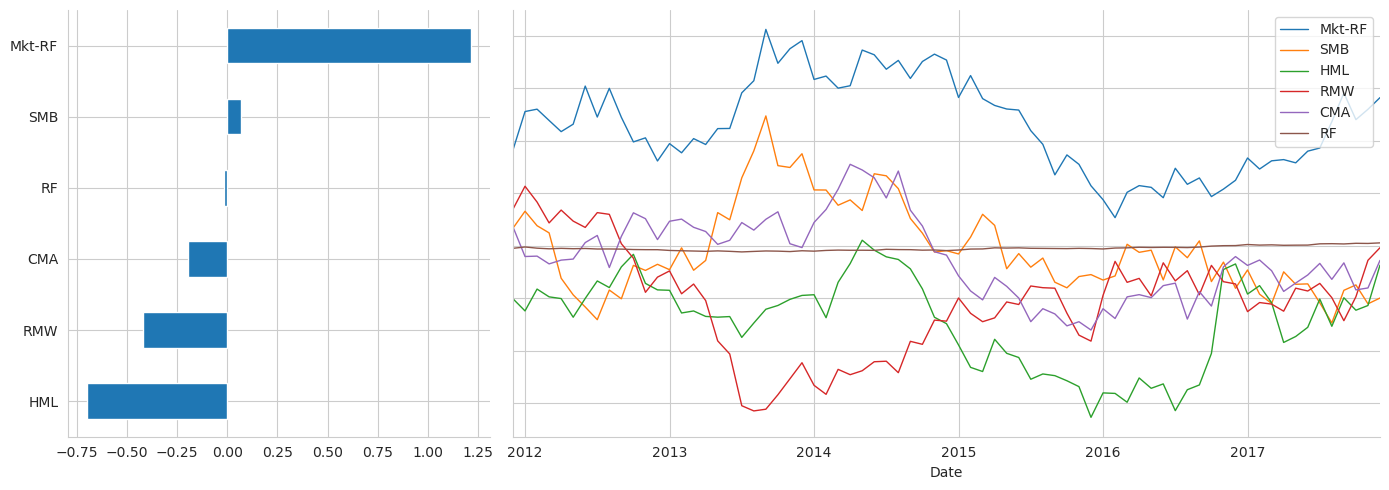

In [6]:
#lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
#sns.despine()
#plt.tight_layout();

#window = 24  # months
#lambdas.rolling(window).mean().dropna().plot(lw=2,figsize=(14, 7),subplots=True,sharey=True)
#sns.despine()
#plt.tight_layout()

window = 24  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,figsize=(14, 5),sharey=True,ax=ax2)
sns.despine()
plt.tight_layout()